# Project 2: Introduction to machine learning - Unsupervised learning

Author: Jakob Nyström

Date: 2021-02-28

### Introduction

In this project we will work with different methods for unsupervised learning. This involves both clustering (k-means and Gaussian mixture models) and methods for dimensionality reduction (Principal components analysis and autoencoders). The basis of the project will be the so called Iris dataset, which contains 150 observations of iris flowers belonging to three different classes. Each flower is described by its sepal and petal lenght and width. 

In [475]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

import keras
from keras import layers
from keras import regularizers
from keras import initializers

## Part 1: Introduction

### 1a) Supervised vs unsupervised learning

The difference between these two families of learning techniques is what information about the target variable is provided to the model. In the case of supervised learning (e.g. regression or classification) the true value of the y variable (a numeric value or a certain class) is given to the model during training, so that the model can learn to associate certain covariates with a certain range of values or a certain class. On the contrary, in unsupervised learning algorithms (e.g. clustering or dimensionality reduction), the model does not get to see the value of the target value, but needs to find patterns in the other available features. In the case of clustering, this means assigning observations to groups that are related to each other, purely based on their characteristics, and without knowing the true classes in the data. 


### 1b) Exploring the dataset

We start by loading the dataset to a dataframe and plotting the different features to see if there are some initial interesting patterns in the data. We plot the distribution of the different features and also create a correlation graph to see if some of them seem to be correlated with each other.

There are 150 observations in total in the sample.

In [224]:
# Load dataset into dataframe

iris = datasets.load_iris()
cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris_df = pd.DataFrame(iris['data'], columns=cols[:4])
iris_df['class'] = iris.target
#print(iris.DESCR)
iris_df

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [3]:
# Checking number of observations

iris_df.shape

(150, 4)

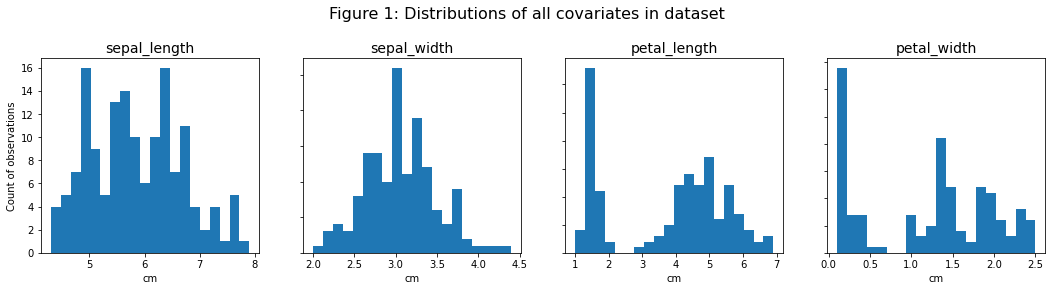

In [4]:
# Plot distributions for each of the features

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
fig.subplots_adjust(top=0.8)

axs[0].hist(iris_df[cols[0]], bins=20)
axs[0].set_title('sepal_length', fontsize=14)
axs[1].hist(iris_df[cols[1]], bins=20)
axs[1].set_title('sepal_width', fontsize=14)
axs[2].hist(iris_df[cols[2]], bins=20)
axs[2].set_title('petal_length', fontsize=14)
axs[3].hist(iris_df[cols[3]], bins=20)
axs[3].set_title('petal_width', fontsize=14)

for ax in axs.flat:
    ax.set(ylabel='Count of observations', xlabel='cm')

for ax in axs.flat: 
    ax.label_outer()
    
fig.suptitle('Figure 1: Distributions of all covariates in dataset', fontsize=16)

print()
plt.show()

For sepal length and width, there is no clear distinction in the data - if we were to smoothen the curve it looks approximately normally distributed. For petal length and width however, there is one group of observations that is smaller than the rest and separated from the rest of the observations (no overlap). Perhaps this is a characteristic of one of the underlying classes in the data - it seems those covariates will be important in the clustering.

Next, we create a correlation plot to see to what extent the covariates are correlated with each other.

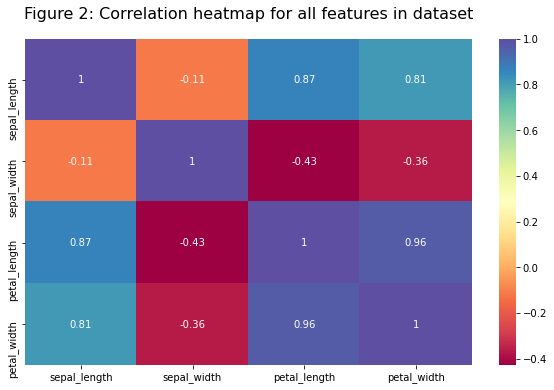

In [60]:
# Plot correlation values in heatmap

iris_corr = iris_df.drop(['class'], axis='columns').corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(iris_corr, annot=True, cmap='Spectral')
plt.title('Figure 2: Correlation heatmap for all features in dataset', fontsize=16, pad=20)

print()
plt.show()

It's worth noting some strong relationships in the plot above (Figure 2). For example, sepal length has a strong positive correlation with petal length and petal width, but on the contrary low correlation with the width of the sepal. The sepal width is negatively correlated with petal width and length, although the relationship is weaker than the previous one described.

In the pair-wise plots below we show some these relationships in more detail (Figure 3). Just like in the histograms, it seems there is at least one class / group of observations that is clearly separated from the the rest.

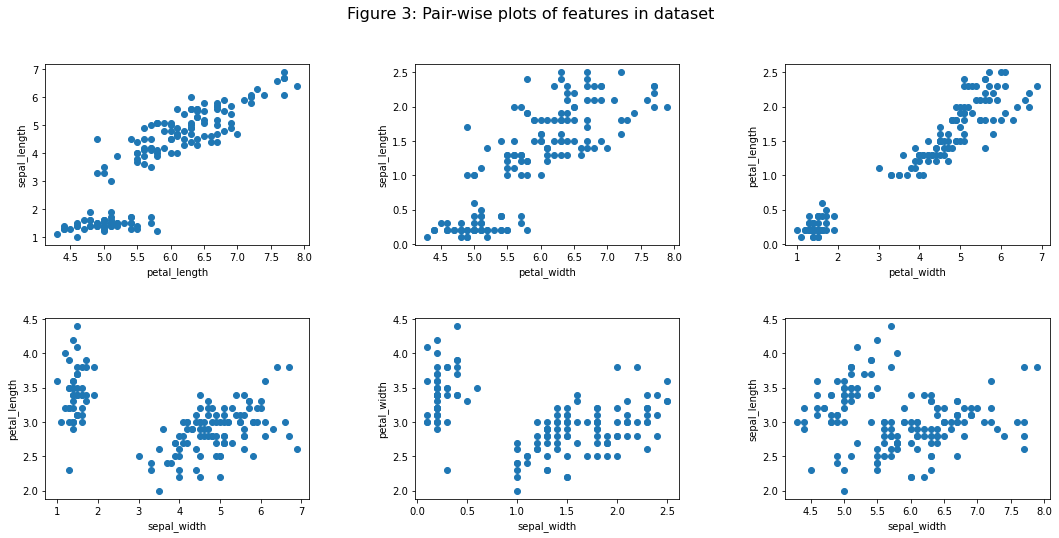

In [262]:
# Pair-wise plots of different features in dataset

fig, axs = plt.subplots(2, 3, figsize=(18, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0, 0].scatter(iris_df['sepal_length'], iris_df['petal_length']) 
axs[0, 0].set(ylabel='sepal_length', xlabel='petal_length')
axs[0, 1].scatter(iris_df['sepal_length'], iris_df['petal_width']) 
axs[0, 1].set(ylabel='sepal_length', xlabel='petal_width')
axs[0, 2].scatter(iris_df['petal_length'], iris_df['petal_width']) 
axs[0, 2].set(ylabel='petal_length', xlabel='petal_width')
axs[1, 0].scatter(iris_df['petal_length'], iris_df['sepal_width']) 
axs[1, 0].set(ylabel='petal_length', xlabel='sepal_width')
axs[1, 1].scatter(iris_df['petal_width'], iris_df['sepal_width']) 
axs[1, 1].set(ylabel='petal_width', xlabel='sepal_width')
axs[1, 2].scatter(iris_df['sepal_length'], iris_df['sepal_width']) 
axs[1, 2].set(ylabel='sepal_length', xlabel='sepal_width')
    
fig.suptitle('Figure 3: Pair-wise plots of features in dataset', fontsize=16)

print()
plt.show()

## Part 2: K-means

### 2a) Intro to K-means clustering

In the k-means clustering algorithm, data is divided into k different clusters, with k being a hyperparameter of the model. The first step in the process is selecting the value of k, and defining the starting values for the centroids (different strategies exist for this, but in general it's a good idea to have them well apart). Each point in the dataset is then assigned to the closest centroid, creating k clusters. These centroids are then updated and points re-assigned in a iterative process. The overall goal of the process is to minimize the (Euclidian) distance between the points within each cluster. 

More formally, the K-means algorithm aims to minimize the within-cluster sum-of-squares (also called distortion or inertia):

$$ J = \sum_{i=1}^{N}\sum_{k=1}^{K}r_{n,k}||x_{n} - \mu_{k}||^2$$ where $$r_{n,k} \in \{0, 1\}$$ 

so that the squared differences is computed for observations $x_{n}$ that belong to cluster $k$. 

That is, the models tries to choose the $\mu_{j}$ for each cluster, which is the average value of all points within a certain cluster, in a way that minimizes the distance between that average and the points. For each iteration of the process there are two steps:

- 1) $J$ is minimized with respect to $r_{n,k}$ and $\mu_k$ is fixed. This implies re-assigning points between clusters
- 2) $J$ is minimized with respect to $\mu_k$ and $r_{n,k}$ is fixed. I.e. new centroids are calculated

1) is a binary choice depending on what minimizes the squared expression. For 2) we take the derivative and set that to 0. Repeat the process until convergence. 

- 1) Choose $r_{n,k} = \begin{cases} 1 & if & k = argmin_{j} ||x_{n} - \mu_{k}||^2 \\ 0 & else \end{cases}$


- 2) $2 \sum_{i=1}^{N} r_{n,k} (x_{n} - \mu_{k}) = 0 \Rightarrow \mu_{k} = \frac{\sum r_{n,k} x_{n}}{\sum r_{n,k}}$



Hopefully, if the starting centroids were well chosen, we reach a global minimum. It should be noted that there is a risk that we end of in a local minimum depending on the choice of starting centroids.


### 2b) Elbow plot to find an optimal K

Since we don't know how many classes actually exist in the underlying data, it's hard to know a priori what is the right value of K. To try to assess what this value should be, i.e. how many clusters there seems to be in the underlying data, we create a loop that clusters the data into k = 1, 2, ..., n clusters and create a so called "elbow plot" with the number of clusters on the x axis and the clustering score on the y axis. The score is based on the expression above that we are trying to minimize (the sum of squared distances to the cluster mean).

In [556]:
# Set up K means model and loop through different values of K. 
# For each K we do 10 loops and take the average score, to improve robustness

X = iris_df.drop(['class'], axis='columns')
k_min = 1
k_max = 11
score_dict = {k: [] for k in range(k_min, k_max)}

for k in range(k_min, k_max):
    for i in range(10): 
        k_means = KMeans(n_clusters=k).fit(X)
        score_dict[k].append(-k_means.score(X))

k_list = []
score_list = []

for k, score in score_dict.items():
    avg_score = round(sum(score) / len(score), 3)
    score_dict[k] = avg_score
    k_list.append(k)
    score_list.append(avg_score)
    
print('Table 1: Distortion score as a function of K value')
print()
print('K value\t\tScore (inertia)')
print()
for k, score in score_dict.items():
    print(f'{k}\t\t{score}')

Table 1: Distortion score as a function of K value

K value		Score (inertia)

1		681.371
2		152.348
3		78.851
4		57.239
5		46.446
6		39.048
7		34.45
8		30.168
9		28.215
10		26.349


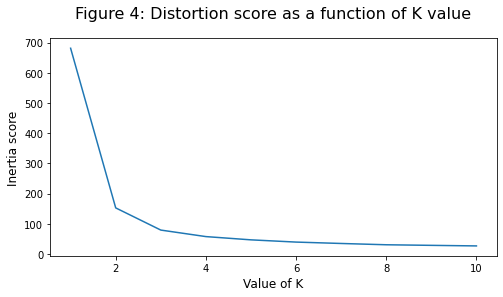

In [557]:
# Use the numbers above to create an elbow plot

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(k_list, score_list)
plt.xlabel('Value of K', fontsize=12)
plt.ylabel('Inertia score', fontsize=12)
plt.title('Figure 4: Distortion score as a function of K value', fontsize=16, pad=20)

print()
plt.show()

What we are looking for in Figure 4 is the point where the curve stops declining quickly and instead flattens out. The K value at this point should be a decent approximation to the amount of underlying clusters. The reason is that before this point, adding more clusters clearly improves the clustering score, i.e. points that are distributed far apart get assigned to the same cluster, explaining the poor score. As we add more clusters, we reach a point where more cluster only have a marginal effect on the score - this is an indication that we are now starting to partition underlying clusters into sub-clusters, which is not what we want.

The choice between 2 and 3 is tricky, but I would tend to go for 3 based on the plot above, since the decline between 2 and 3 is still quite steep (and trying to ignore the fact that I know there are 3 types of irises in the underlying data).


### 2c) Cluster data and compare to actual labels

In this step we use the algorithm with a value of k = 3 to cluster the data, and then compare this with the actual labels in the dataset. The results are visible in Figure 5 and Table 2.

In [274]:
# Cluster data using k = 3 

k_means = KMeans(n_clusters=3).fit(X)

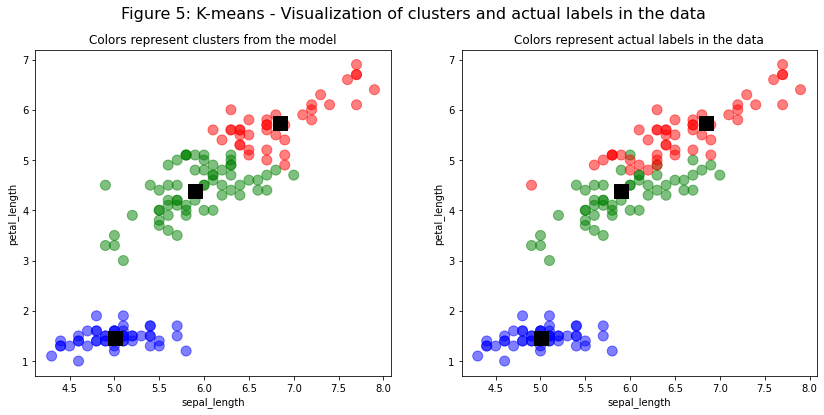

In [278]:
# Plot cluster and real labels to compare

clusters = k_means.labels_
actual_labels = iris_df['class']
centroids = k_means.cluster_centers_

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

colors_1 = ['green', 'blue', 'red']
colors_2 = ['blue', 'green', 'red']

axs[0].scatter(iris_df['sepal_length'], iris_df['petal_length'], c=clusters, s=100,
           cmap=matplotlib.colors.ListedColormap(colors_1), alpha=0.5)
axs[0].scatter(centroids[:,0], centroids[:,2], c='black', marker='s', s=200)
axs[0].set(title='Colors represent clusters from the model', xlabel='sepal_length', ylabel='petal_length')

axs[1].scatter(iris_df['sepal_length'], iris_df['petal_length'], c=actual_labels, s=100,
           cmap=matplotlib.colors.ListedColormap(colors_2), alpha=0.5)
axs[1].scatter(centroids[:,0], centroids[:,2], c='black', marker='s', s=200)
axs[1].set(title='Colors represent actual labels in the data', xlabel='sepal_length', ylabel='petal_length')

plt.suptitle('Figure 5: K-means - Visualization of clusters and actual labels in the data', fontsize=16)

print()
plt.show()

In the left graph of Figure 5, each color represents a cluster as clustered by the model. The black squares are the cluster centroids (same in both graphs). As suggested by the initial data inspection, the model has found one cluster that is clearly separated from the other two, in the lower left corner. In the right graph, the color mapping is instead given by the actual iris class in the underlying data. We can see that the blue cluster perfectly coincides with the blue class on the right - in this case the model does a great job of separating that class as its own cluster. 

For the red and green classes it's more difficult, as they are not perfectly separated when plotting by the features above, and also indicated by the original scatter plots. We can clearly see that although the clustering gets most of the observations right, there are several red points to the right that the model mistake for belonging to the green cluster - cases where the sepal length and petal length are at the lower end for the red class.

It's not surprising that the model gets it wrong when there are overlapping values for some features between two underlying clusters, since the model will assign the points to the centroid that minimizes the squared distance and the K-means model works best with spherical data, while here the shape is more elliptical. In Figure 6 we do the same with petal and sepal width, and results are similar: the blue cluster is perfectly separated while the model is struggling with the red and green clusters. 

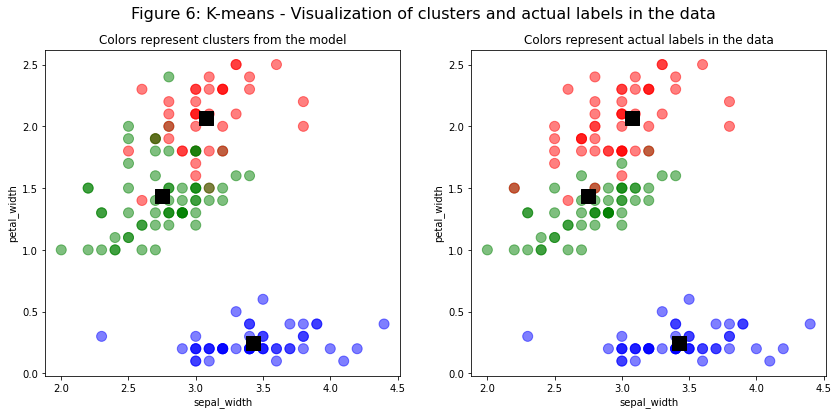

In [293]:
# Create same plot as above, with different x and y labels

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

colors_1 = ['green', 'blue', 'red']
colors_2 = ['blue', 'green', 'red']

axs[0].scatter(iris_df['sepal_width'], iris_df['petal_width'], c=clusters, s=100,
           cmap=matplotlib.colors.ListedColormap(colors_1), alpha=0.5)
axs[0].scatter(centroids[:, 1], centroids[:, 3], c='black', marker='s', s=200)
axs[0].set(title='Colors represent clusters from the model', xlabel='sepal_width', ylabel='petal_width')

axs[1].scatter(iris_df['sepal_width'], iris_df['petal_width'], c=actual_labels, s=100,
           cmap=matplotlib.colors.ListedColormap(colors_2), alpha=0.5)
axs[1].scatter(centroids[:, 1], centroids[:, 3], c='black', marker='s', s=200)
axs[1].set(title='Colors represent actual labels in the data', xlabel='sepal_width', ylabel='petal_width')

plt.suptitle('Figure 6: K-means - Visualization of clusters and actual labels in the data', fontsize=16)

print()
plt.show()

Finally, we check how many observations for each class that were correctly clustered, results in Table 2. 

In [298]:
# Compare cluster labels with class labels
# Clusters 1, 0, 2 correspond to classes 0, 1, 2

clusters_sorted = []

# Sort clusters in the right order for comparison
for label in clusters.tolist():
    if label == 1:
        clusters_sorted.append(0)
    elif label == 0:
        clusters_sorted.append(1)
    else:
        clusters_sorted.append(2)

comp_table = pd.DataFrame({'Cluster label': clusters_sorted, 
                           'Actual label': actual_labels})

# Create column with 1 or 0 if clustering was right or wrong
def accuracy_check(row):
    if row['Cluster label'] == row['Actual label']:
        return 1
    else:
        return 0

comp_table['Correct'] = comp_table.apply(lambda row: accuracy_check(row), axis=1) 

# Count correct labels per cluster to get accuracy
sum_table = pd.DataFrame({'Cluster': ['Blue', 'Green', 'Red'], 
                          'Points assigned': comp_table.groupby(['Cluster label'])['Correct'].count(), 
                          'Actual points': comp_table.groupby(['Actual label'])['Actual label'].count(), 
                         'Correctly clustered': comp_table.groupby(['Cluster label'])['Correct'].sum()})

print()
print('Table 2: K-means - Cluster labels compared to actual labels')
sum_table


Table 2: K-means - Cluster labels compared to actual labels


,Cluster,Points assigned,Actual points,Correctly clustered
0,Blue,50,50,50
1,Green,62,50,48
2,Red,38,50,36


The results are in line with what was seen in the plots. The blue cluster is completely correct. There are too many points assigned to the green cluster, and conversely too few assigned to the red one.


## Part 3: Gaussian mixtures

### 3a) Intro to Gaussian mixtures clustering

A Gaussian mixture model (GMM) is another approach for clustering data. It assumes that each underlying cluster in the data represent a different normal distribution with different $\mu$ and $\sigma$ (these are the so called Guassian mixtures). So if $x_{k}$ belongs to cluster k, then $x_{k} \sim N(\mu_{k}, \sum_{k})$.

Each point in the dataset has a probability of belonging to each cluster, given by the mixture coefficient $\Pi$ so if we sum the probabilities across all k we get a probability of 1: $$f(x) = \sum_{k=1}^{K} \Pi_{k} N(x | \mu_{k}, \sum_{k})$$ 

The EM algorithm (expectation maximization) can be used to find the parameter values for the GMM. Similar to K-means we start with some assumptions on the values of the parameters and then follow certain steps in an iterative process, until we reach convergence:

- 1) Guess some values for $\mu_{k}, \sum_{k}, \Pi_{k}$

- 2) Calculate the expected value of the likelihood for data given current parameters (the E step)

- 3) Update these values to maximize the likelihood function (the M step)

Steps 2 and 3 are repeated until convergence is reached.

### 3b-d) Clustering with GM and EM

In this part we will perform the clustering using Gaussian mixtures and the EM algorithm. We use the same K that was used for the K-means clustering. We use the same plots and tables as for the K means algorithm to visualize and evaluate the results compared to the actual classes in the dataset.

In [284]:
# Cluster using GMM with EM algorithm

gaussian = GaussianMixture(n_components=3).fit(X)
gaussian_labels = gaussian.predict(X)

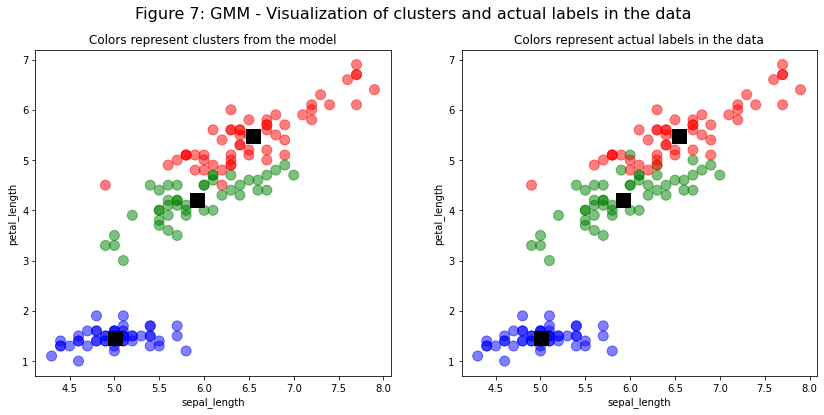

In [294]:
# Plot the results compared to the actual labels in the data

gaussian_means = gaussian.means_
actual_labels = iris_df['class'] 

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

colors_1 = ['green', 'blue', 'red']
colors_2 = ['blue', 'green', 'red']

axs[0].scatter(iris_df['sepal_length'], iris_df['petal_length'], c=gaussian_labels, s=100,
           cmap=matplotlib.colors.ListedColormap(colors_1), alpha=0.5)
axs[0].scatter(gaussian_means[:,0], gaussian_means[:,2], c='black', marker='s', s=200)
axs[0].set(title='Colors represent clusters from the model', xlabel='sepal_length', ylabel='petal_length')

axs[1].scatter(iris_df['sepal_length'], iris_df['petal_length'], c=actual_labels, s=100,
           cmap=matplotlib.colors.ListedColormap(colors_2), alpha=0.5)
axs[1].scatter(gaussian_means[:,0], gaussian_means[:,2], c='black', marker='s', s=200)
axs[1].set(title='Colors represent actual labels in the data', xlabel='sepal_length', ylabel='petal_length')

plt.suptitle('Figure 7: GMM - Visualization of clusters and actual labels in the data', fontsize=16)

print()
plt.show()

From Figure 7, we can see that the GMM model does a significantly better job of clustering the data compared to the simple K-means model. In the borderline area between the red and the green clusters, the model assigns more points to the correct cluster, even the red outlier point to the left. For comparison, we plot the clusters of the K-means and the GMM next to each other below in Figure 8.

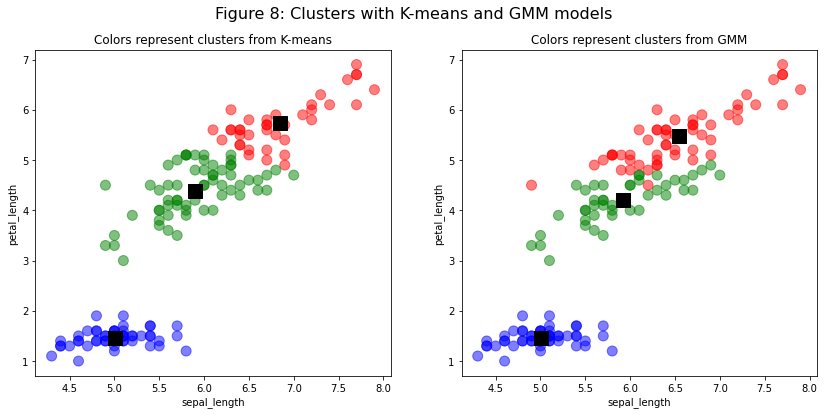

In [289]:
# Plot K-means vs GMM clustering

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

colors_1 = ['green', 'blue', 'red']
colors_2 = ['green', 'blue', 'red']

axs[0].scatter(iris_df['sepal_length'], iris_df['petal_length'], c=clusters, s=100,
           cmap=matplotlib.colors.ListedColormap(colors_1), alpha=0.5)
axs[0].scatter(centroids[:,0], centroids[:,2], c='black', marker='s', s=200)
axs[0].set(title='Colors represent clusters from K-means', xlabel='sepal_length', ylabel='petal_length')

axs[1].scatter(iris_df['sepal_length'], iris_df['petal_length'], c=gaussian_labels, s=100,
           cmap=matplotlib.colors.ListedColormap(colors_2), alpha=0.5)
axs[1].scatter(gaussian_means[:,0], gaussian_means[:,2], c='black', marker='s', s=200)
axs[1].set(title='Colors represent clusters from GMM', xlabel='sepal_length', ylabel='petal_length')

plt.suptitle('Figure 8: Clusters with K-means and GMM models', fontsize=16)

print()
plt.show()

We can clearly see that there is one part of the red class, towards the lower left of that cluster, which the GMM model is (mostly) correctly clustering as red, while the K-means model assigns these points to the green cluster. In Table 3 below we confirm that the GMM performs better than K-means on this data - it gets a vast majority of points right also for the red and green clusters. 

In [299]:
# Compare cluster labels with class labels
# Clusters 1, 0, 2 correspond to classes 0, 1, 2

clusters_sorted = []

# Sort clusters in the right order for comparison
for label in gaussian_labels.tolist():
    if label == 1:
        clusters_sorted.append(0)
    elif label == 0:
        clusters_sorted.append(1)
    else:
        clusters_sorted.append(2)

comp_table = pd.DataFrame({'Cluster label': clusters_sorted, 
                           'Actual label': actual_labels})

# Create column with 1 or 0 if clustering was right or wrong
def accuracy_check(row):
    if row['Cluster label'] == row['Actual label']:
        return 1
    else:
        return 0

comp_table['Correct'] = comp_table.apply(lambda row: accuracy_check(row), axis=1) 

# Count correct labels per cluster to get accuracy

sum_table = pd.DataFrame({'Cluster': ['Blue', 'Green', 'Red'], 
                          'Points assigned': comp_table.groupby(['Cluster label'])['Correct'].count(), 
                          'Actual points': comp_table.groupby(['Actual label'])['Actual label'].count(), 
                         'Correctly clustered': comp_table.groupby(['Cluster label'])['Correct'].sum()})

print()
print('Table 3: GMM - Cluster labels compared to actual labels')
sum_table


Table 3: GMM - Cluster labels compared to actual labels


,Cluster,Points assigned,Actual points,Correctly clustered
0,Blue,50,50,50
1,Green,45,50,45
2,Red,55,50,50


### 3e) Excluding lower probability observations

Since the output of the GMM model is a probability that some observation is belonging to a cluster, we can also exclude the ones we are less confident in. Below we exclude all observations that have less than 95% probability of belonging to its cluster.

In [300]:
# Get probability of the labels that were assigned

gaussian_prob = gaussian.predict_proba(X)
gaussian_labels = gaussian.predict(X)

max_prob = []
for observation in gaussian_prob:
    max_prob.append(round(max(observation), 3))

comp_table_2 = pd.DataFrame({'Cluster label': clusters_sorted, 
                           'Actual label': actual_labels, 
                             'Probability': max_prob})

# Exclude any observations that has prob < 0.95

comp_table_2.drop(labels_prob[labels_prob['Probability'] < 0.95].index, inplace=True)

# Create column with 1 or 0 if clustering was right or wrong

comp_table_2['Correct'] = comp_table_2.apply(lambda row: accuracy_check(row), axis=1) 

# Count correct labels per cluster to get accuracy

sum_table_2 = pd.DataFrame({'Cluster': ['Blue', 'Green', 'Red'], 
                          'Points assigned': comp_table_2.groupby(['Cluster label'])['Correct'].count(), 
                          'Actual points': comp_table_2.groupby(['Actual label'])['Actual label'].count(), 
                         'Correctly clustered': comp_table_2.groupby(['Cluster label'])['Correct'].sum()})

print()
print('Table 4: GMM - Cluster labels compared to actual labels when probability > 0.95')
sum_table_2


Table 4: GMM - Cluster labels compared to actual labels when probability > 0.95


,Cluster,Points assigned,Actual points,Correctly clustered
0,Blue,50,50,50
1,Green,37,41,37
2,Red,53,49,49


Excluding probabilities < 95% doesn't change the picture for the first cluster. For the green cluster, 37 out of 41 points are correctly assigned, vs 45 out of 50 before, so a small marginal improvement. For the red cluster, we now assign 53 points where the real number should be 49, compared to 55 out of 50 before. So again a very small improvement in accuracy compared to before.


### 3f) Difference between GMM and K-means

Since the K-means model uses the Euclidian distance to the centroid, it has issues with cluster shapes that are not spherical. This is clearly illustrated in our iris dataset, e.g. in Figure 3 above, which shows that the clusters are more elliptical in shape for most combinations of features. Another disadvantage is that it doesn't give any measure of uncertainty for the labels assigned - it performs "hard" clustering. 

These issues are partly solved with the GMM model. First of all, it handles the elliptical shaped clusters better, which is one reason it performs better in clustering the red and green classes. Second, it also provides a measure of probability of each point being assigned to the different clusters ("soft" clustering), which we used in 3e). On the other hand, it takes longer to converge than K-means. 

It is actually possible to derive the K-means algorithm as a particular limit of EM for Gaussian mixtures. This is the case where the mixture components share a variance parameter $\in$ and this is treated as a constant rather than a parameter to be re-estimated. When this constant goes towards 0, we get a hard assignment of points to clusters, which is exactly what we get from the K-means algorithm.


## Part 4: Principal components analysis (PCA)


### 4a) Intro to PCA

Principal component analysis is one way of conducting dimensionality reduction, which is transformation of data with high dimensionality (many features) to a lower dimensionality (fewer features). In such a process we try to preserve the important aspects of data, while removing noise. This can e.g. help overcome "curse of dimensionality" by reducing the amount dimensions when later performing classification or regression.  

More formally, PCA involves projection of data onto a subspace so that the variance of the projected points is maximized. We want to project data onto a subspace that has $M < D$ dimensions ($D$ being the original dimensionality of data). We start by defining a D-dimensional vector $u_{1}$. Then each data point $x_{n}$ is multiplied with the transpose of the vector $u_{1}^{t}x_{n}$. Then the total variance of the projected data is given by $$\frac{1}{N} \sum_{n}^{N} (u_{1}^{t}x_{n} - u_{1}^{t} \bar{x})^2 = u_{1}^{t} S u_{1}$$   

where $S$ is the covariance matrix. We then introduce a Langrange multiplier and maximize this expression with respect to $u_{1}$ $$ \max_{u_{1}} u_{1}: u_{1}^{t} S u_{1} + \lambda (1 - u_{1}^{t} u_{1})$$

We take the derative which we set to 0, and the variance is maximized when we choose $u_{1}$ as the eigenvector with the largest eigenvalue. This vector is called the first principal component. Then we can find additional vectors that are orthogonal to the first principal component, which give the subsequent principal components.

There might be reasons to normalize data before performing PCA. Especially in the case where different features have different units and therefore different orders of magnitude, the result will be less biased towards features with large units (and thereby large variance) if we normalize first. Since in our case, all features are measured in cm and there is not a massive difference between them, this will be less critical, but likely still makes sense to do.


### 4b) Conducting PCA on the dataset

We will now use PCA on the 4 feature columns in the dataset and see how much of the total variance that the first principal component can explain. Data is centered in the default sklearn implementation, so we will keep this setting (it turns out normalizing the data beforehand doesn't change the result at all, either). Furthermore, we will set the number of components equal to the number of features in the data. 

In [554]:
# Conduct PCA and check how much variance is explained by the principal components

norm_X = Normalizer().fit(X)
norm_X.transform(X)

comp = 4
pca = PCA(n_components=comp).fit(X)

var_expl = pca.explained_variance_
perc_expl = pca.explained_variance_ratio_

print()
print('Table 5: Variance explained by principal components')
print()
print('Component\tVar explained\t% var explained')
for i in range(comp):
    print(f'{i + 1}\t\t{round(var_expl[i], 3)}\t\t{round(perc_expl[i], 3)}')


Table 5: Variance explained by principal components

Component	Var explained	% var explained
1		4.228		0.925
2		0.243		0.053
3		0.078		0.017
4		0.024		0.005


We can see from Table 5 that the first component explains as much as 92% of the total variance in the dataset, which is a very high number. The rest of the components add only marginally to explaining the variance. 

### 4c) Plot principal components

In this step we create a plot that has the two first principal components as their axes. We put it next to one of the original plats, which has petal and sepal length, for reference. In both plots we color the observations based on the true classes in the underlying data. 

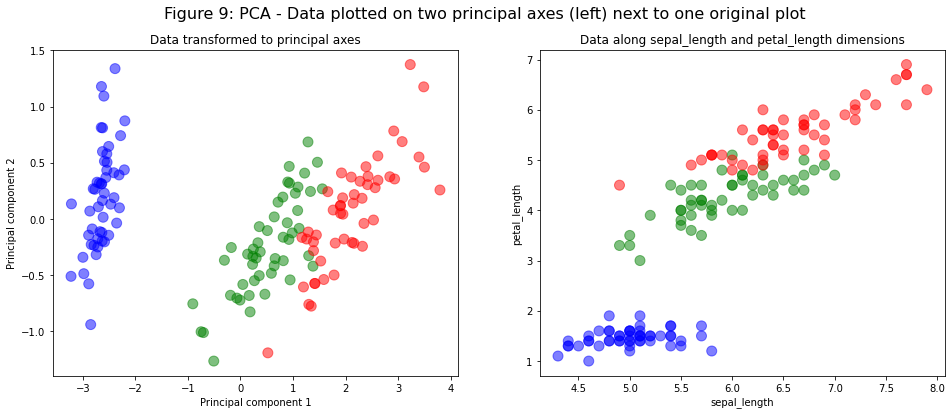

In [555]:
comp = 2
pca = PCA(n_components=comp).fit(X)
pca_transform = pca.transform(X)

pca_comp = np.array([[pca.components_[0][0], pca.components_[0][2]], 
                     [pca.components_[1][0], pca.components_[1][2]]])

pca_mean = np.array([pca.mean_[0], pca.mean_[2]])

pca_1 = []
pca_2 = []
for observation in pca_transform:
    pca_1.append(observation[0])
    pca_2.append(observation[1])

# Plot the results

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

colors = ['blue', 'green', 'red']

axs[0].scatter(pca_1, pca_2, c=actual_labels, s=100,
           cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
axs[0].set(title='Data transformed to principal axes', xlabel='Principal component 1', ylabel='Principal component 2')

# Compare to one of the original plots     

axs[1].scatter(iris_df['sepal_length'], iris_df['petal_length'], c=actual_labels, s=100,
           cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
axs[1].set(title='Data along sepal_length and petal_length dimensions', xlabel='sepal_length', ylabel='petal_length')

plt.suptitle('Figure 9: PCA - Data plotted on two principal axes (left) next to one original plot', fontsize=16)

print()
plt.show()

When representing the data using the first two principal components, the data is indeed relatively well separated. Just like before, the blue class is not overlapping with the others. However, there is still some overlapp between the green and red classes, meaning these principal components cannot perfectly separate the different clusters.


## Part 5: Autoencoders


### 5a) Intro to autoencoders

Autoencoders is a neural network used for unsupervised learning. It essentially maps $D$ inputs to $D$ outputs through one or more hidden layers with $M < D$ nodes. It has two use cases:

- a) If we want to clean up noise in the data, we take the output from the output layer.
- b) If we want to reduce dimensionality, we take the output from one of the hidden layers that has lower dimensionality (fewer nodes) than the input and output layer.

Just like in a neural network for supervised learning, we want to minimize the error function $$E(w) = \frac{1}{e} \sum_{n=1}^N ||y(x{n}, w) - x_{n}||^2$$ 

where $y$ is a function of inputs $x$ and weights $w$.


### 5b) Creating an autoencoder model

In this step we will set up and autoencoder model with the aim of finding a 2-dimensional representation of the data that separates the three species. In this process we need to select the number of neurons and hidden layers in the model. In the end I chose three hidden layers, the first with 4 neurons, the second with 2, and the third with 4.

In [551]:
# Model set-up and training

# Set dimensions for layers
input_dim = 4
encoding_dim_1 = 4
encoding_dim_2 = 2

# Define the different layers in the model
input_data = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim_1, activation='relu')(input_data)
encoded = layers.Dense(encoding_dim_2, activation='relu')(encoded)

decoded = layers.Dense(encoding_dim_1, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='relu')(decoded)

# Model that maps input to reconstruction
autoencoder = keras.Model(input_data, decoded)

# Model that maps input to encoded representation
encoder = keras.Model(input_data, encoded)

# The encoded input
encoded_input = keras.Input(shape=(encoding_dim_1,))
# Last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
 
# Set configurations of the model, set up training and test data
autoencoder.compile(loss='mean_squared_error', optimizer='adam')

x_train, x_test = train_test_split(X, test_size=0.2, shuffle=True)
norm_train = Normalizer().fit(x_train)
norm_train.transform(x_train)
norm_test = Normalizer().fit(x_test)
norm_test.transform(x_test)

# Train the model
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test));

### 5c-d) Results of autoencoder compared to PCA

In Figure 10 below, we can see the data points plotted on the two dimensions in the "bottleneck layer" of the autoencoder (to the left) and the PCA plot as shown earlier in Figure 9 (to the right).

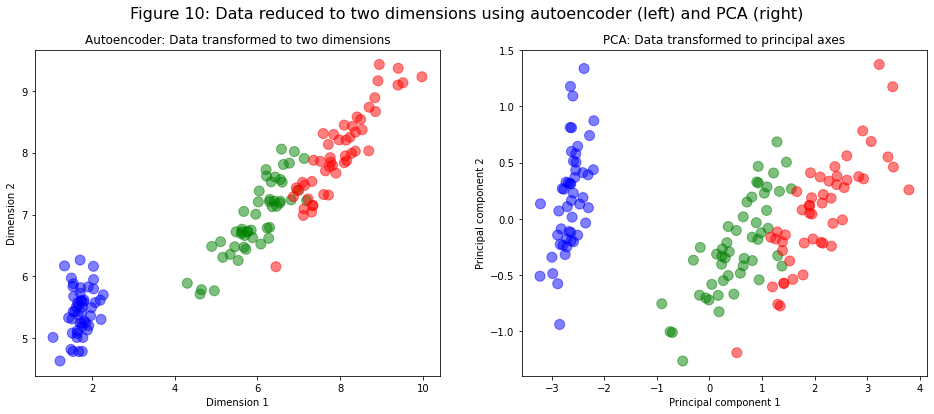

In [552]:
# Apply the model to transform the data and plot the results

encoded_points = encoder.predict(X)
#decoded_points = decoder.predict(encoded_points)

dim_1 = []
dim_2 = []
for observation in encoded_points:
    dim_1.append(observation[0])
    dim_2.append(observation[1])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

colors = ['blue', 'green', 'red']

axs[0].scatter(dim_1, dim_2, c=actual_labels, s=100,
           cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
axs[0].set(title='Autoencoder: Data transformed to two dimensions', xlabel='Dimension 1', ylabel='Dimension 2')

# Compare to one of the original plots     

axs[1].scatter(pca_1, pca_2, c=actual_labels, s=100,
           cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
axs[1].set(title='PCA: Data transformed to principal axes', xlabel='Principal component 1', ylabel='Principal component 2')

plt.suptitle('Figure 10: Data reduced to two dimensions using autoencoder (left) and PCA (right)', fontsize=16)

print()
plt.show()

Results between the autoencoder and PCA can be seen above in Figure 10. After running a very high number of experiments with different layers, neurons, number of epochs and batch sizes, something like the above is the best output I've been able to get - roughly on par with the PCA. There's not a perfect separation between green and red, but it looks decent. For most of the runs, the model ends up in a local minimum or doesn't converge, meaning the results often end up on a straight line (horisontal, vertical or diagonal) where clusters are not clearly separated, or in a single point.


### 5e) PCA vs autoencoders

The main benefit of autoencoders is that it works on non-linear problems. PCA only work in cases of linear manifolds on which the data is projected. By adding more than one hidden layer in the autoencoder this problem can be overcome. The two methods are essentially equivalent in the case of only one hidden layer in the autoencoder, that has linear activation functions. 

## Part 6: Summary and conclusion

In this project we've used different techniques for clustering and dimensionality reduction. Starting with K-means, which is a very simple method for clustering, we were able to correctly cluster one of the iris species (blue) but the model had some issues separating the red and green clusters, since data had an elliptical rather than spherical shape. Results improved when we used Guassian mixture models (GMM) for the clustering, with most irises clustered correctly. Thus GMM proved to be the preferable model for clustering.

Moving on to dimensionality reduction, we first used PCA to find the two most important principal components in the data. We were able to represent the underlying data on these two dimensions with a fairly clear separation between red and green clusters - however, some points were still overlapping in this representation. We then moved on to training an autoencoder, which is a neural network for dimensionality reduction. It proved very difficult to train a model that was better than the PCA in representing the data with clear separation between clusters. The model had difficulties converging at a stable solution, potentially due to the limited amount of training data. Here I would prefer using PCA due to it's stability and reasonable performance.